In [1]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K

In [2]:
# for reproducing reslut
from numpy.random import seed
seed(1)
import tensorflow 
tensorflow.random.set_seed(3)

In [3]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 256
k = 8
k = int(k)
n_channel = 8
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 256 k: 8 n: 8


In [4]:
#generating data of size N
N = 8000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [6]:
# checking data shape
data = np.array(data)
print (data.shape)

(8000, 256)


In [7]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

25 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
212 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [8]:
from keras.layers import Layer

class RicianNoise(Layer):
    def __init__(self, sigma, K_factor, **kwargs):
        self.sigma = sigma
        self.K_factor = K_factor
        super(RicianNoise, self).__init__(**kwargs)

    def call(self, inputs):
        # Generate Rician fading and add to the signal
        rician = K.random_normal(K.shape(inputs), mean=self.K_factor, stddev=self.sigma)
        signal = K.sqrt((inputs + rician)**2)
        return signal

    def get_config(self):
        config = {'sigma': self.sigma, 'K_factor': self.K_factor}
        base_config = super(RicianNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# defining autoencoder and its layers
input_signal = Input(shape=(M,))
encoded = Dense(128, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1)

EbNo_train = 5.01187 # coverted 7 db of EbNo
encoded3 = RicianNoise(np.sqrt(1/(2*R*EbNo_train)), K_factor=0.5)(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')


C:\Users\Surya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 lambda (Lambda)             (None, 8)                 0         
                                                                 
 rician_noise (RicianNoise)  (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 256)               2304      
                                                                 
 dense_3 (Dense)             (None, 256)               65792 

In [10]:
# for tensor board visualization
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# traning auto encoder
autoencoder.fit(data, data,
                epochs=45,
                batch_size=32)

Epoch 1/45
250/250 [==============================] - 2s 4ms/step - loss: 3.0097
Epoch 2/45
250/250 [==============================] - 1s 4ms/step - loss: 1.2745
Epoch 3/45
250/250 [==============================] - 1s 4ms/step - loss: 0.9779
Epoch 4/45
250/250 [==============================] - 1s 5ms/step - loss: 0.8212
Epoch 5/45
250/250 [==============================] - 1s 5ms/step - loss: 0.7101
Epoch 6/45
250/250 [==============================] - 1s 5ms/step - loss: 0.6833
Epoch 7/45
250/250 [==============================] - 1s 4ms/step - loss: 0.6013
Epoch 8/45
250/250 [==============================] - 1s 5ms/step - loss: 0.5699
Epoch 9/45
250/250 [==============================] - 2s 8ms/step - loss: 0.5604
Epoch 10/45
250/250 [==============================] - 2s 8ms/step - loss: 0.5625
Epoch 11/45
250/250 [==============================] - 2s 8ms/step - loss: 0.5208
Epoch 12/45
250/250 [==============================] - 2s 8ms/step - loss: 0.5052
Epoch 13/45
250/250 [====

In [11]:
# saving keras model
from keras.models import load_model

In [12]:
encoder = Model(input_signal, encoded2)
# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [13]:
# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500
N = 50000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)
# checking generated data
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

1.0 229
1/1 [==============================] - 0s 31ms/step
(256, 1, 8)


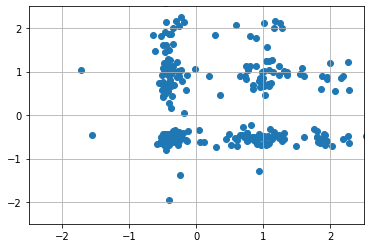

In [14]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,8,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [15]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

1563/1563 [==============================] - 5s 3ms/step
SNR: -4 BER: 0.94648
1563/1563 [==============================] - 4s 2ms/step
SNR: -3.5 BER: 0.94232
1563/1563 [==============================] - 4s 2ms/step
SNR: -3.0 BER: 0.93824
1563/1563 [==============================] - 4s 2ms/step
SNR: -2.5 BER: 0.9321
1563/1563 [==============================] - 3s 2ms/step
SNR: -2.0 BER: 0.92516
1563/1563 [==============================] - 4s 2ms/step
SNR: -1.5 BER: 0.92138
1563/1563 [==============================] - 3s 2ms/step
SNR: -1.0 BER: 0.91456
1563/1563 [==============================] - 3s 2ms/step
SNR: -0.5 BER: 0.90508
1563/1563 [==============================] - 4s 2ms/step
SNR: 0.0 BER: 0.89786
1563/1563 [==============================] - 3s 2ms/step
SNR: 0.5 BER: 0.89264
1563/1563 [==============================] - 4s 2ms/step
SNR: 1.0 BER: 0.88356
1563/1563 [==============================] - 4s 2ms/step
SNR: 1.5 BER: 0.87744
1563/1563 [==============================] - 4s

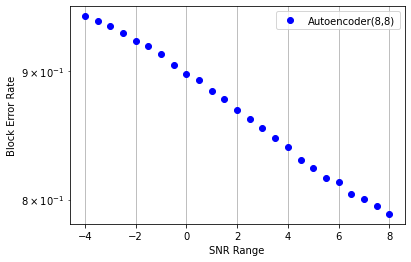

In [16]:
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(8,8)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
# for saving figure remove below comment
plt.savefig('AutoEncoder_8_8_constrained_BER_matplotlib')
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model

# Set up the MIMO system
num_receivers = 4
num_transmitters = 4

# Set up the autoencoder
input_layer = Input(shape=(num_receivers,))
encoded_layer = Dense(num_transmitters, activation='relu')(input_layer)
decoded_layer = Dense(num_receivers, activation='linear')(encoded_layer)
autoencoder = Model(input_layer, decoded_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Set up the encoder and decoder separately
encoder = Model(input_layer, encoded_layer)
decoder_layer = autoencoder.layers[-1]
decoder = Model(autoencoder.input, decoder_layer(autoencoder.input))

# Generate random messages to send
num_messages = 1000
messages = np.random.randint(0, 2, size=(num_messages, num_transmitters))

# Generate the transmitted signals
tx_signal = 2 * messages - 1

# Generate the received signals for different channels
signal_noise_ratios = [5, 10, 15, 20]
num_channels = len(signal_noise_ratios)
rx_signals = np.zeros((num_channels, num_messages, num_receivers))

In [18]:
for i, snr in enumerate(signal_noise_ratios):
    for j in range(num_messages):
        h = np.random.randn(num_receivers, num_transmitters) / np.sqrt(2)
        noise = np.random.randn(num_receivers) / np.sqrt(2 * snr)
        rx_signals[i,j] = np.dot(h, tx_signal[j].T) + noise

# Train the autoencoder for each channel
num_epochs = 50
batch_size = 32
for i in range(num_channels):
    autoencoder.fit(rx_signals[i], rx_signals[i], epochs=num_epochs, batch_size=batch_size, verbose=0)

# Evaluate the bit error rate for each channel
bers = []
for i in range(num_channels):
    encoded_messages = encoder.predict(rx_signals[i])
    decoded_signal = decoder.predict(encoded_messages)
    ber = np.mean(np.abs(decoded_signal - messages) > 0.5)
    print(f'Channel {i}: Bit error rate: {ber}')
    bers.append(ber)

32/32 [==============================] - 0s 2ms/step
Channel 0: Bit error rate: 0.75875
32/32 [==============================] - 0s 2ms/step
Channel 1: Bit error rate: 0.75175
32/32 [==============================] - 0s 2ms/step
Channel 2: Bit error rate: 0.74625
32/32 [==============================] - 0s 2ms/step
Channel 3: Bit error rate: 0.75975


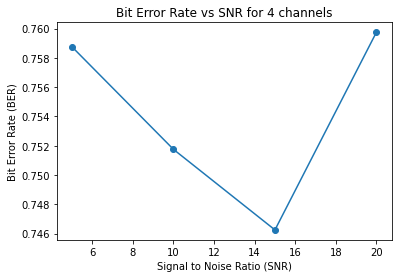

In [19]:
# Plot the bit error rate vs SNR
plt.plot(signal_noise_ratios, bers, marker='o')
plt.title('Bit Error Rate vs SNR for 4 channels')
plt.xlabel('Signal to Noise Ratio (SNR)')
plt.ylabel('Bit Error Rate (BER)')
plt.show()